In [2]:
import os
import astropy
import numpy as np
from astropy.table import Table
from astropy.table import Column
import glob
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

In [3]:
sample_location = "/home/hallflower/sample/spectra/"
dash = "C:/users/20xha/Documents/Caltech/Research/DASH/"

In [5]:
SEDM_ML_sample = Table.read("C:/Users/20xha/Documents/Caltech/Research/SEDM_ML_sample.ascii", format = "ascii")
SEDM_ML_sample.rename_column('col1', 'ZTF_Name')
SEDM_ML_sample.rename_column('col2', "Class")
SEDM_ML_sample.rename_column('col8', "Version")

In [6]:
dashoutput = np.load(dash+"output.npy",allow_pickle=True)

In [7]:
snidoutput = np.load("/home/xhall/Documents/NewZTF/sample_2018/SNID_2018_output.npy", allow_pickle=True)

In [9]:
final_rcf_table = Table.from_pandas(pd.read_hdf("C:/users/20xha/Documents/Caltech/Research/final_rcf_table.h5"))

In [10]:
len(final_rcf_table)

764

In [18]:
ResultsTable_List_confidence = []
ranges = np.linspace(0.1836, 1, 101)
for confidence in ranges:
    count = 0
    ResultsTable = Table(
                    names=("ZTF_Name", "Dash", "Confidence",
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "U64", "float64",
                          )
                    )

    for i in dashoutput:
        row = []
        row.append(i[-1])
        reliable = np.where(np.asarray(i[4]) != 'Unreliable matches')[0]
        if(len(reliable) != 0):
            best = np.asarray(i[2])[:,0][reliable]
            c = Counter(best)
            best_rlap = float(min(np.asarray(i[2])[:,2][reliable]))
            if(best_rlap > confidence):
                row.append(c.most_common()[0][0])
                row.append(best_rlap)
                ResultsTable.add_row(row)

        count += 1
    if(count % 50 == 0):
        print(count)
            
    if(len(ResultsTable) != 0):
        ResultsTable_List_confidence.append([confidence,ResultsTable])

In [19]:
negative = 0
positive = 0
JoinedResults = final_rcf_table
for j in JoinedResults:
    correct_1a = "Ia" in j["sn_type"]
    if(correct_1a):
        positive += 1
    if(not(correct_1a)):
        negative += 1

In [20]:
print(max(ResultsTable_List_confidence[0][1]["Confidence"]))
print(min(ResultsTable_List_confidence[0][1]["Confidence"]))

1.0
0.4093


In [21]:
counters_confidence_1a = [] 
for i in ResultsTable_List_confidence:
    truepositive = 0
    falsepositive = 0
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    
    for j in JoinedResults:
        correct_1a = "Ia" in j["sn_type"]
        classified_1a = "Ia" in j["Dash"]
        if(correct_1a == True and classified_1a == True):
            truepositive += 1
        if(correct_1a != True and classified_1a == True):
            falsepositive += 1
    counters_confidence_1a.append([i[0],truepositive/(positive),falsepositive/(negative),len(JoinedResults)])
counters_confidence_1a = np.asarray(counters_confidence_1a)

In [25]:
tprfpr_dash = Table(
                names=("confidence_dash", "tpr_dash", "fpr_dash"
                ),
                meta={"name": "Comparison of Three Programs"},
                dtype=("float64", "float64", "float64"
                      )) 
for i in ResultsTable_List_confidence:
    truepositive = 0
    falsepositive = 0
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    
    for j in JoinedResults:
        correct_1a = "Ia" in j["sn_type"]
        classified_1a = "Ia" in j["Dash"]
        if(correct_1a == True and classified_1a == True):
            truepositive += 1
        if(correct_1a != True and classified_1a == True):
            falsepositive += 1
    tprfpr_dash.add_row([i[0],truepositive/(positive),falsepositive/(negative)])

In [27]:
from astropy.io import ascii
ascii.write(tprfpr_dash, "tprfpr_dash_confidence.ascii")

In [12]:
ranges = np.linspace(0, 25, 100)
ResultsTable_List_rlap = []
count = 0

for i in ranges:
    ResultsTable = Table(
                    names=("ZTF_Name", "Closest"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "U64"
                          )
                    )
    for j in snidoutput:
        row = []
        row.append(j[0])
        if(np.max(j[1]["rlap"]) > i):
            row.append(j[1][0]["type"])
            ResultsTable.add_row(row)
    
    count += 1
    if(len(ResultsTable) != 0):
        ResultsTable_List_rlap.append([i,ResultsTable])
    if(count% 100 == 0):
        print(count)

100


In [110]:
negative = 0
positive = 0
for j in final_rcf_table:
    correct_1a = "Ia" in j["sn_type"]
    if(correct_1a):
        positive += 1
    if(not(correct_1a)):
        negative += 1

In [16]:
counters_rlap_1a = [] 
for i in ResultsTable_List_rlap:
    truepositive = 0
    falsepositive = 0
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    for j in JoinedResults:
        correct_1a = "Ia" in j["sn_type"]
        classified_1a = "Ia" in j["Closest"]
        if(correct_1a == True and classified_1a == True):
            truepositive += 1
        if(correct_1a != True and classified_1a == True):
            falsepositive += 1
    counters_rlap_1a.append([i[0],truepositive/(positive),falsepositive/(negative),len(JoinedResults), truepositive, falsepositive])
counters_rlap_1a = np.asarray(counters_rlap_1a)

In [17]:
print(positive,negative)
print(truepositive,falsepositive)

547 217
0 0


Text(0, 0.5, 'True Positive Rate')

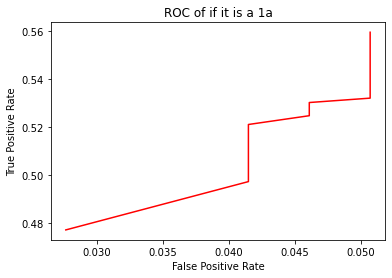

In [22]:
#plt.plot(counters_rlap_1a[:,2], counters_rlap_1a[:,1], color = "blue")
plt.plot(counters_confidence_1a[:,2], counters_confidence_1a[:,1], color = "red")
plt.title("ROC of if it is a 1a")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [13]:
counters_confidence_1a

array([[0.00000000e+00, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [1.00000000e-02, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [2.00000000e-02, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [3.00000000e-02, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [4.00000000e-02, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [5.00000000e-02, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [6.00000000e-02, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [7.00000000e-02, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [8.00000000e-02, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [9.00000000e-02, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [1.00000000e-01, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [1.10000000e-01, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [1.20000000e-01, 5.59414991e-01, 5.06912442e-02, 4.89000000e+02],
       [1.30000000e-01, 5.59414991e-01, 5.06912442e

In [17]:
counters_rlap_1a[np.where(counters_rlap_1a[:,2] == 0)][0]

array([0., 0., 0., 0., 0., 0.])

In [20]:
counters_confidence = [] 
for i in ResultsTable_List_confidence:
    truepositive = 0
    wrong = []
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    for j in JoinedResults:
        if(j["sn_type"] != '-'):
            correct_1a = "Ia" in j["sn_type"]
            classified_1a = "Ia" in j["Dash"]
            if(correct_1a == True and classified_1a == True):
                truepositive += 1
    wrong = np.asarray(wrong)
    counters_confidence.append([i[0],truepositive,positive, wrong])
counters_confidence = np.asarray(counters_confidence)

Text(0, 0.5, 'true positive rate')

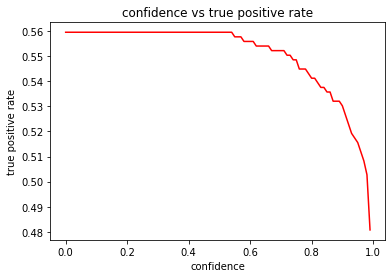

In [21]:
plt.plot(counters_confidence[:,0], counters_confidence[:,1]/(counters_confidence[:,2]), color = "red")
plt.title("confidence vs true positive rate")
plt.xlabel("confidence")
plt.ylabel("true positive rate")

In [22]:
counters_rlap = [] 
for i in ResultsTable_List_rlap:
    counter = 0
    wrong = []
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    for j in JoinedResults:
        correct_1a = "Ia" in j["sn_type"]
        classified_1a = "Ia" in j["Closest"]
        if(correct_1a==classified_1a):
            counter += 1
        else:
            wrong.append([j["ZTF_Name"], j["sn_type"], j["Closest"]])
    wrong = np.asarray(wrong)
    counters_rlap.append([i[0],counter,len(JoinedResults), wrong])
counters_rlap = np.asarray(counters_rlap)

In [45]:
plt.plot(counters_rlap[:,0], counters_rlap[:,1]/counters_rlap[:,2], color = "blue")
plt.xlim(0, 25)
plt.title("rlap vs accuracy")
plt.xlabel("rlap")
plt.ylabel("accuracy")

ZeroDivisionError: division by zero

In [46]:
ResultsTable_List_confidence_rlap = []
ranges = np.linspace(0, 25, 101)
for rlap in ranges:
    count = 0
    ResultsTable = Table(
                    names=("ZTF_Name", "Dash", "Confidence",
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "U64", "float64",
                          )
                    )

    for i in dashoutput:
        row = []
        row.append(i[-1])
        reliable = np.where(np.asarray(i[4]) != 'Unreliable matches')[0]
        if(len(reliable) != 0):
            best = np.asarray(i[2])[:,0][reliable]
            c = Counter(best)
            rlap_list = []
            for rlap_vals in np.asarray(i[3]):
                rlap_list.append(float(rlap_vals.split(":")[-1]))
            best_rlap = np.max(rlap_list)
            if(best_rlap > rlap):
                row.append(c.most_common()[0][0])
                row.append(best_rlap)
                ResultsTable.add_row(row)

        count += 1
    if(count % 50 == 0):
        print(count)
            
    if(len(ResultsTable) != 0):
        ResultsTable_List_confidence_rlap.append([rlap,ResultsTable])

In [47]:
counters_confidence_rlap = [] 
for i in ResultsTable_List_confidence_rlap:
    counter = 0
    wrong = []
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    for j in JoinedResults:
        if(j["sn_type"] != '-'):
            correct_1a = "Ia" in j["sn_type"]
            classified_1a = "Ia" in j["Dash"]
            if(correct_1a==classified_1a):
                counter += 1
            else:
                wrong.append([j["ZTF_Name"], j["sn_type"], j["Dash"]])
    wrong = np.asarray(wrong)
    if(counter != 0):
        counters_confidence_rlap.append([i[0],counter,len(JoinedResults), wrong])
counters_confidence_rlap = np.asarray(counters_confidence_rlap)

Text(0, 0.5, 'true positive')

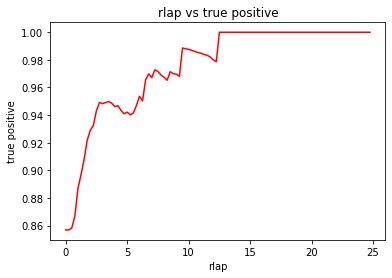

In [48]:
plt.plot(counters_confidence_rlap[:,0], counters_confidence_rlap[:,1]/counters_confidence_rlap[:,2], color = "red")
plt.title("rlap vs true positive")
plt.xlabel("rlap")
plt.ylabel("true positive")

ZeroDivisionError: division by zero

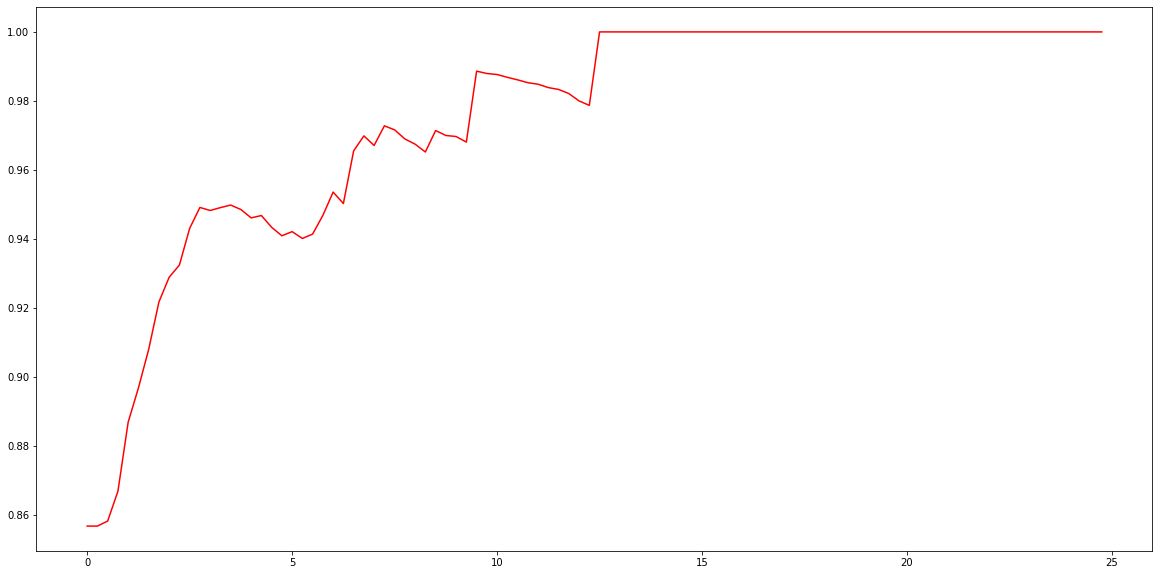

In [49]:
fig = plt.figure(figsize = (20,10))
plt.plot(counters_confidence_rlap[:,0], counters_confidence_rlap[:,1]/counters_confidence_rlap[:,2], color = "red")
plt.plot(counters_rlap[:,0], counters_rlap[:,1]/counters_rlap[:,2], color = "blue")
plt.title("rlap vs Accuracy")
plt.xlabel("rlap")
plt.ylabel("Accuracy")

In [50]:
counters_confidence_1a_rlap = [] 
for i in ResultsTable_List_confidence_rlap:
    truepositive = 0
    falsepositive = 0
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    
    for j in JoinedResults:
        correct_1a = "Ia" in j["sn_type"]
        classified_1a = "Ia" in j["Dash"]
        if(correct_1a == True and classified_1a == True):
            truepositive += 1
        if(correct_1a != True and classified_1a == True):
            falsepositive += 1
    counters_confidence_1a_rlap.append([i[0],truepositive/(positive),falsepositive/(negative),len(JoinedResults), truepositive, falsepositive])
counters_confidence_1a_rlap = np.asarray(counters_confidence_1a_rlap)

Text(0, 0.5, 'True Positive Rate')

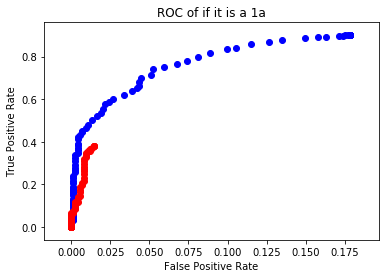

In [174]:
snidroc = plt.scatter(counters_rlap_1a[:,2], counters_rlap_1a[:,1], color = "blue")
dashroc = plt.scatter(counters_confidence_1a_rlap[:,2], counters_confidence_1a_rlap[:,1], color = "red")
#plt.text(counters_rlap_1a[:,2], counters_rlap_1a[:,1], counters_rlap_1a[:,0])
plt.title("ROC of if it is a 1a")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [175]:
TPRFPRSNID = Table(
                    names=("FPR", "TPR",
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("float64", "float64",
                          )
                    )
for i in zip(counters_rlap_1a[:,2], counters_rlap_1a[:,1]):
    TPRFPRSNID.add_row(i)

In [176]:
TPRFPRDASH = Table(
                    names=("FPR", "TPR",
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("float64", "float64",
                          )
                    )
for i in zip(counters_confidence_1a_rlap[:,2], counters_confidence_1a_rlap[:,1]):
    TPRFPRDASH.add_row(i)

In [177]:
astropy.io.ascii.write(TPRFPRSNID, 'TPRFPRSNID.ascii', format='fast_tab', fast_writer=False) 
astropy.io.ascii.write(TPRFPRDASH, 'TPRFPRDASH.ascii', format='fast_tab', fast_writer=False) 

In [52]:
counters_confidence_1a_rlap[np.where(counters_confidence_1a_rlap[:,2] == 0)][0]

array([9.50000000e+00, 6.35910224e-02, 0.00000000e+00, 8.80000000e+01,
       5.10000000e+01, 0.00000000e+00])

In [ ]:
ResultsTable_List_confidence_rlap = []
ranges = np.linspace(0, 25, 6)
for rlap in ranges:
    count = 0
    ResultsTable = Table(
                    names=("ZTF_Name", "Dash", "Confidence",
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "U64", "float64",
                          )
                    )

    for i in dashoutput:
        row = []
        row.append(i[-1])
        reliable = np.where(np.asarray(i[4]) != 'Unreliable matches')[0]
        if(len(reliable) != 0):
            best = np.asarray(i[2])[:,0][reliable]
            c = Counter(best)
            rlap_list = []
            for rlap_vals in np.asarray(i[3]):
                rlap_list.append(float(rlap_vals.split(":")[-1]))
            best_rlap = np.max(rlap_list)
            if(best_rlap > rlap):
                row.append(c.most_common()[0][0])
                row.append(best_rlap)
                ResultsTable.add_row(row)

        count += 1
    if(count % 50 == 0):
        print(count)
            
    if(len(ResultsTable) != 0):
        ResultsTable_List_confidence_rlap.append([rlap,ResultsTable])

In [ ]:
ranges = np.linspace(0, 25, 6)
ResultsTable_List_rlap = []
count = 0

for i in ranges:
    ResultsTable = Table(
                    names=("ZTF_Name", "Closest"
                    ),
                    meta={"name": "Spectrum Results after SNID"},
                    dtype=("U64", "U64"
                          )
                    )
    for j in snidoutput:
        row = []
        row.append(j[0])
        if(np.max(j[1]["rlap"]) > i):
            row.append(j[1][0]["type"])
            ResultsTable.add_row(row)
    
    count += 1
    if(len(ResultsTable) != 0):
        ResultsTable_List_rlap.append([i,ResultsTable])
    if(count% 100 == 0):
        print(count)

In [ ]:
counters_confidence_1a_rlap = [] 
for i in ResultsTable_List_confidence_rlap:
    truepositive = 0
    falsepositive = 0
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    
    for j in JoinedResults:
        correct_1a = "Ia" in j["sn_type"]
        classified_1a = "Ia" in j["Dash"]
        if(correct_1a == True and classified_1a == True):
            truepositive += 1
        if(correct_1a != True and classified_1a == True):
            falsepositive += 1
    counters_confidence_1a_rlap.append([i[0],truepositive/(positive),falsepositive/(negative),len(JoinedResults), truepositive, falsepositive])
counters_confidence_1a_rlap = np.asarray(counters_confidence_1a_rlap)

In [ ]:
counters_rlap_1a = [] 
for i in ResultsTable_List_rlap:
    truepositive = 0
    falsepositive = 0
    JoinedResults = astropy.table.join(i[1], final_rcf_table)
    for j in JoinedResults:
        correct_1a = "Ia" in j["sn_type"]
        classified_1a = "Ia" in j["Closest"]
        if(correct_1a == True and classified_1a == True):
            truepositive += 1
        if(correct_1a != True and classified_1a == True):
            falsepositive += 1
    counters_rlap_1a.append([i[0],truepositive/(positive),falsepositive/(negative),len(JoinedResults), truepositive, falsepositive])
counters_rlap_1a = np.asarray(counters_rlap_1a)

In [ ]:
fig = plt.figure(figsize = (10,10))
plt.scatter(counters_rlap_1a[:,2], counters_rlap_1a[:,1], color = "blue")
plt.scatter(counters_confidence_1a_rlap[:,2], counters_confidence_1a_rlap[:,1], color = "red")
for i in counters_rlap_1a:
    plt.text(i[2]+.002,i[1]+.002,">"+str(i[0]))
for i in counters_confidence_1a_rlap:
    plt.text(i[2]+.002,i[1]+.002,">"+str(i[0]))
plt.title("TPR vs. FPR for different rlap thresholds")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

In [ ]:
counters_rlap_1a[0]

In [ ]:
actual_c = Counter(final_rcf_table["sn_type"])
actual_list = np.flip(np.asarray(actual_c.most_common()))

In [ ]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_axes([0,0,1,1])
ax.bar(actual_list[:,1], actual_list[:,0].astype(int), label = "Wrong")